# Remove response

## import function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as  mpl
import csv
import obspy

In [66]:
def find_response_file(path, idb = None, ifs = None, iFilter = None, iLC = None, mode = 'COUNTS',inverted=True, plot='True') :
    '''
    function to find metadata in the logfile
    
    path : path of the logfile - is a string
    idb : force the gain - From 0 to 36 B - is a integer, float or string
    ifs : force the sampling frequency - 50, 100, 125, 250, 500, 1000, 2000 or 4000 Hz - is a integer, float or string
    iFilter : force the Final Filter Phase - could be LP or MP - is a string
    iLC : force the DC Filter - could be 'OFF', '1' or 'DC' - is a string
    
    mode = 'COUNTS' or 'mV'
    interted = True or False - if True, the polarization has been already inverted

    '''
    
    
    with open(path) as file :
        readcsv = csv.reader(file, delimiter=' ')
        line = 0
        db = np.zeros(4)
        for row in readcsv :
            #print(row)
            if row != [] :
                if row[0] == 'Project' :
                    pj = row[-1]
                if row[0] == "Serial" :
                    sr = row[-1]
                if row[0] == "Channel" and row[2] == "Gain":
                    c = int(row[1]) - 1
                    db[c] = round(np.exp(0.1155*int(row[-1])))
                if row[0] == "Anti-alias" :
                    if row[-1] == 'Linear' :
                        Filter = 'LP'
                    else :
                        Filter = 'MP'
                if row[0] == "Sample" and row[1] == "Rate" :
                    fs = int(row[-1])
                if row[0] == "Low" and row[1] == "Cutter" :
                    if int(row[-1]) == 0 :
                        LC = 'Off'
                    elif int(row[-1]) == 1 :
                        LC = '1'
                    else :
                        LC = 'DC'
                        
    if idb != None :
        db[0] = round(np.exp(0.1155*int(idb)))
    elif idb == None:
        idb = int(np.log(db[0])/0.1155)
    if ifs != None :
        fs = int(ifs)
    if iFilter != None :
        Filter = str(iFilter)  
    if iLC != None :
        LC = str(iLC)

    from obspy.clients.nrl import NRL

    nrl = NRL()

    response_node = nrl.get_response(
    datalogger_keys=['DTCC (manufacturers of SmartSolo','SmartSolo IGU-16HR3C', '%s dB (%i)'%(idb, db[0]), '%s'%fs, 'Linear Phase', '%s' %LC],
        sensor_keys=['DTCC (manuafacturers of SmartSolo)', 'DT-SOLO' , '5 Hz', 'Rc=1850, Rs=430000'])
    print(response_node)
    response_node.response_stages[0].stage_gain = 76.7
    response_node.recalculate_overall_sensitivity()

    if plot == True :
        response_node.plot(min_freq=0.001, output='VEL')

    if inverted == True:
        inv = 1
    else :
        inv = -1

    if mode == 'COUNTS' :
        paz_node = {'poles': response_node.get_paz().poles,
        'zeros': response_node.get_paz().zeros,
        'gain': 3355.4428*inv, # need to invert the trace for some reason
        'sensitivity': response_node.instrument_sensitivity.value}

    elif mode == 'mV' :
        paz_node = {'poles': response_node.get_paz().poles,
        'zeros': response_node.get_paz().zeros,
        'gain': -1.,
        'sensitivity': response_node.instrument_sensitivity.value}
    else :
        raise ValueError('mode should be either COUNTS or mV')
    
    
    return paz_node 

In [67]:
from obspy import read_inventory

def simulate_mseed(stream, logfile_path, pre_filt = None, plot=True) :
    
    '''
    Function to remove the response of minions based on the obspy remove_response function
    
    stream --> obspy stream object
    
    logfile_path : path of the logfile - is a string
    pre_filt : prefilter of obspy remove_response function
    output : output parameter of obspy remove_response function - could be 'VEL', 'DISP', 'ACC' or 'DEF'
    zero_mean (bool) : If True, the mean of the waveform data is subtracted in time domain prior to deconvolution.
    water_level (float) : Water level for deconvolution.
    taper (bool) : If True, a cosine taper is applied to the waveform data in time domain prior to deconvolution.
    taper_fraction (float) : Taper fraction of cosine taper to use.
    
    Parameters for the find_response_file function :
    
    idb : force the gain - From 0 to 36 B - is a integer, float or string
    ifs : force the sampling frequency - 50, 100, 125, 250, 500, 1000, 2000 or 4000 Hz - is a integer, float or string
    iFilter : force the Final Filter Phase - could be LP or MP - is a string
    iLC : force the DC Filter - could be 'OFF', '1' or 'DC' - is a string
    
    '''
    
    trace = stream[0]

    #net = trace.stats.network
    #station =  trace.stats.station
    #ch =  trace.stats.channel
    #loc = trace.stats.location

    ifs = trace.stats.sampling_rate
    
    if trace.stats.mseed.encoding in ['STEIM2','STEIM1','INT32','INT16'] :
        mode = 'COUNTS'
    elif trace.stats.mseed.encoding == 'FLOAT32' :
        mode = 'mV'
    else :
        raise ValueError('Encoding not recognized')
    
    if plot not in [True, False] :
        raise ValueError('plot should be either True or False')

    paz_node = find_response_file(logfile_path, ifs = ifs, plot=plot)

    
    if pre_filt == None :
        pre_filt = (0.05, 0.06, ifs//2 - 5, ifs//2)

    stream.simulate(
        paz_remove=paz_node,
        remove_sensitivity=True,
        pre_filt=pre_filt)


    return stream

In [68]:
def remove_resp_mseed(trace, logfile_path, pre_filt = None, output = "VEL", zero_mean=False, water_level=60,plot=False,
                idb = None, ifs = None, iFilter = None, iLC = None) :    
    '''
    Function to remove the response of minions based on the obspy remove_response function
    
    --> Needs improvements, currently not working

    trace --> obspy trace
    
    logfile_path : path of the logfile - is a string
    pre_filt : prefilter of obspy remove_response function
    output : output parameter of obspy remove_response function - could be 'VEL', 'DISP', 'ACC' or 'DEF'
    zero_mean (bool) : If True, the mean of the waveform data is subtracted in time domain prior to deconvolution.
    water_level (float) : Water level for deconvolution.
    taper (bool) : If True, a cosine taper is applied to the waveform data in time domain prior to deconvolution.
    taper_fraction (float) : Taper fraction of cosine taper to use.
    
    Parameters for the find_response_file function :
    
    idb : force the gain - From 0 to 36 B - is a integer, float or string
    ifs : force the sampling frequency - 50, 100, 125, 250, 500, 1000, 2000 or 4000 Hz - is a integer, float or string
    iFilter : force the Final Filter Phase - could be LP or MP - is a string
    iLC : force the DC Filter - could be 'OFF', '1' or 'DC' - is a string
    
    '''
    from obspy.core.inventory.response import Response


    #net = trace.stats.network
    #station =  trace.stats.station
    #ch =  trace.stats.channel
    #loc = trace.stats.location

    ifs = trace.stats.sampling_rate
    
    if trace.stats.mseed.encoding in ['STEIM2','STEIM1','INT32','INT16'] :
        mode = 'COUNTS'
    elif trace.stats.mseed.encoding == 'FLOAT32' :
        mode = 'mV'
    else :
        raise ValueError('Encoding not recognized')

    paz_node = find_response_file(logfile_path, ifs = ifs)
    resp = Response.from_paz(paz_node['poles'], paz_node['zeros'], paz_node['gain'], paz_node['sensitivity'], input_units=mode, output_units='M/S')
    print(resp)
    pre_filt = (0.05, 0.06, ifs//2 - 5, ifs//2)

    trace.remove_response(resp, output=output, pre_filt=pre_filt, zero_mean=zero_mean, water_level=water_level, plot=plot)

    return trace

## Get metadata information from log file

In [69]:
path = 'D:/GitHub/ULB-SeismoLab/Minions-Toolbox/ExampleData/Log/453001250/20231110162230/DigiSolo.LOG'
paz_node = find_response_file(path)
print(paz_node)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 4.9001e+06 defined at 25.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 76.6
		Stage 2: ResponseStage from V to V, gain: 64
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
{'poles': [(-22.2111-22.2178j), (-22.2111+22.2178j)], 'zeros': [0j, 0j], 'gain': 3355.4428, 'sensitivity': 4906497.352699268}


C:\Users\julie\AppData\Local\Temp\ipykernel_13596\751132783.py:59: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


## Remove response

In [70]:
file_path = 'D:/GitHub/ULB-SeismoLab/Minions-Toolbox/ExampleData/Miniseed/'
file = '453004444..0.0001.2023.11.10.11.09.45.000.N.miniseed'
st = obspy.read(file_path+file)

In [71]:
file_path = 'D:/GitHub/ULB-SeismoLab/Minions-Toolbox/ExampleData/Miniseed/'
file = '453004444..0.0001.2023.11.10.11.09.45.000.N.miniseed'
st = obspy.read(file_path+file)
trace = st[0]
trace.stats

         network: BE
         station: 04444
        location: BE
         channel: GPN
       starttime: 2023-11-10T11:09:45.000000Z
         endtime: 2023-11-10T12:56:33.000000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 6408001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 3749, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 15355904})

C:\Users\julie\AppData\Local\Temp\ipykernel_13596\751132783.py:59: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 4.90185e+06 defined at 50.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 76.6
		Stage 2: ResponseStage from V to V, gain: 64
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


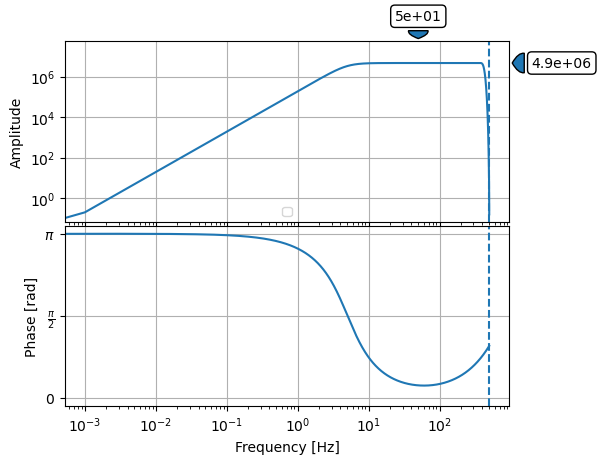

In [72]:
path = 'D:/GitHub/ULB-SeismoLab/Minions-Toolbox/ExampleData/Log/453004444/20231110141508/DigiSolo.LOG'
rst = simulate_mseed(st, path)

## Save data with the removed response

In [9]:
output_st = obspy.Stream(rtrace)
output_st.write('./ResponseRemoved/CR_'+file, format="MSEED")

C:\Users\julie\anaconda3\envs\bas2\lib\site-packages\obspy\io\mseed\core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)
